TODO: 
- ! Think about what plots would suit the current question and hypotheses the best, e.g., histogram?
- ! Preprocessing of speeches and external data
- Quantify the speech column. 
    - Currently: Compare words in speech to words in labeled climate change dataset. 
    Problem: languages, the classifier will only work for English texts. 

Another option would be to use classifier to analyze every sentence in every speech. 
The result (sum?) of this could be added to a new column in `df_speech`. 
But currently the model has very low accuracy score compared to the paper: https://s3.us-east-1.amazonaws.com/climate-change-ai/papers/neurips2020/69/paper.pdf

In this notebook the prepared data will be visualised.

#### 0. Prepare the data

##### a) Load the daset containing the speeches

In [1]:
import os
import numpy as np
import pandas as pd

sessions = np.arange(25, 76)
data = []

for session in sessions:
    directory = "data/TXT/Session " + str(session) + " - " + str(1945 + session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0] == ".": #ignore hidden files
            continue
        splt = filename.split("_")
        # Start from 1995
        if session < 50:
            continue
        data.append([session, 1945 + session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_speech.head() # Shape: (4913, 4)

,Session,Year,ISO-alpha3 Code,Speech
0,50,1995,BDI,The United Nations is celebrating its fiftieth...
1,50,1995,VNM,"Allow me at the outset, on behalf of the\ndele..."
2,50,1995,PAK,"I extend to you, Sir, my\ndelegation’s felicit..."
3,50,1995,MLI,We\nare meeting on the eve of the fiftieth ann...
4,50,1995,FRA,"Mr. President, I should like to say first how\..."


In [2]:
# Load recent speeches
from pdfminer.high_level import extract_text

year = 2022
session = 76
folder = f'data/PDF/Session_76 - {year}/'

data = []

for file in os.listdir(folder):
    f = open(os.path.join(folder, file), "rb")

    splt = file.split("_")
    data.append([session, year, splt[0], extract_text(f)])

df_recent = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech = pd.concat([df_speech, df_recent])

##### b) Load the dataset containing the expenses

In [3]:
# Load COFOG
cofog = pd.read_csv("data/gov_10a_exp__custom_3469207_page_tabular.tsv", sep='\t')

cofog.iloc[:,0] = cofog.iloc[:,0].str.split(',').str[-1]
cofog.rename(columns={cofog.columns[0]: "ISO-alpha2 Code"}, inplace=True)

# Perform some preprocessing
cofog = cofog.melt(id_vars=["ISO-alpha2 Code"], var_name="Year", value_name='Expenses')
cofog['Year'] = cofog['Year'].astype(int)
cofog['Expenses'] = cofog['Expenses'].astype(str).str.strip().str.extract(r'(\d+.\d+)').astype('float')

cofog.head()

,ISO-alpha2 Code,Year,Expenses
0,AT,1995,55.8
1,BE,1995,52.6
2,BG,1995,31.7
3,CH,1995,33.3
4,CY,1995,30.9


COFOG contains ISO-alpha2 Code while `df_speeches` has ISO-alpha3 codes. We can use another external dataset that uses both.

##### c) Load dataset containing all names of countries and codes

In [4]:
df_codes = pd.read_csv("data/UNSD — Methodology.csv", delimiter=';')

df_un_merged = cofog.merge(df_codes, how='inner') # Df goes from 832 -> 754, but don't know why!!!
df_un_merged = df_un_merged[["ISO-alpha3 Code", "ISO-alpha2 Code", "Expenses", "Country or Area", "Year", "Region Name", "Sub-region Name"]]

df_un_merged.head()

,ISO-alpha3 Code,ISO-alpha2 Code,Expenses,Country or Area,Year,Region Name,Sub-region Name
0,AUT,AT,55.8,Austria,1995,Europe,Western Europe
1,AUT,AT,55.6,Austria,1996,Europe,Western Europe
2,AUT,AT,52.3,Austria,1997,Europe,Western Europe
3,AUT,AT,52.2,Austria,1998,Europe,Western Europe
4,AUT,AT,52.1,Austria,1999,Europe,Western Europe


##### d) Merge datasets
Now we have a COFOG dataframe and a speeches which can be merged with the corresponding `ISO-alpha3` codes and the specific year. We also remove non-European countries.

In [5]:
df_speech = df_speech.merge(df_un_merged, how='inner', on=['Year', 'ISO-alpha3 Code'])
df_speech.head()

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe
3,50,1995,ISL,"Mr. President, may I\ncongratulate you on your...",IS,NaN,Iceland,Europe,Northern Europe
4,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe


##### e) Clean the `Speech` column

In [6]:
# Copy speech to new column
df_speech['Text'] = df_speech.loc[:,'Speech'].copy()

In [7]:
from nltk import word_tokenize
from nltk.corpus import stopwords

def preprocess(words):
    """
    Returns list with words without stopwords and interpunction
    """
    sw = stopwords.words("english")
    clean = []
    for w in words:
        w = str.lower(w)
        if (w not in sw) and (w.isalpha()):
            clean.append(w)

    return clean

# ! Warning, cell takes longer: about 40 seconds
df_speech.loc[:,'Text'] = df_speech.loc[:,'Text'].apply(word_tokenize)
df_speech.loc[:,'Text'] = df_speech.loc[:,'Text'].apply(preprocess)

In [8]:
df_speech.head()

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name,Text
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe,"[president, like, say, first, pleased, france,..."
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe,"[warmly, congratulate, president, election, pr..."
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe,"[today, ever, realize, delegations, many, coun..."
3,50,1995,ISL,"Mr. President, may I\ncongratulate you on your...",IS,NaN,Iceland,Europe,Northern Europe,"[president, may, congratulate, election, expre..."
4,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe,"[may, extend, congratulations, sir, upon, elec..."


##### f) Quantify the attention for the topic of climate change by  the Member States

In [9]:
# Loading the labeled dataset
climate = pd.read_json('data/climate-fever-dataset-r1.jsonl', lines=True) # Source https://www.sustainablefinance.uzh.ch/en/research/climate-fever.html

# Retrieve the values remove the uncertain ones
climate = climate[(climate.claim_label != 'DISPUTED') & (climate.claim_label != 'NOT_ENOUGH_INFO')]

climate.head()

,claim_id,claim,claim_label,evidences
0,0,Global warming is driving polar bears toward e...,SUPPORTS,[{'evidence_id': 'Extinction risk from global ...
1,5,The sun has gone into ‘lockdown’ which could c...,SUPPORTS,"[{'evidence_id': 'Famine:386', 'evidence_label..."
2,6,The polar bear population has been growing.,REFUTES,"[{'evidence_id': 'Polar bear:1332', 'evidence_..."
3,9,Ironic' study finds more CO2 has slightly cool...,REFUTES,"[{'evidence_id': 'Atmosphere of Mars:131', 'ev..."
4,10,Human additions of CO2 are in the margin of er...,REFUTES,[{'evidence_id': 'Carbon dioxide in Earth's at...


In [10]:
# Extract claims and clean
claims = ' '.join([i for i in set(climate.claim.values)])

climate_words = word_tokenize(claims)
climate_words = preprocess(climate_words)

print(len(climate_words)) # 10215

10215


In [11]:
def count_occurrences(words):
    counts = {}
    count = 0
    for word in words:
        if word in climate_words:
            if word in counts.keys():
                counts[word] += 1
            else:
                counts[word] = 0
    total = sum(counts.values())
    return total

# Warning, cell takes long: over 1m
df_speech['Count'] = df_speech['Text'].apply(count_occurrences)

In [12]:
df_speech['Count'].head(100)

0     636
1     668
2     311
3     240
4     279
     ... 
95    366
96    235
97    266
98    391
99    603
Name: Count, Length: 100, dtype: int64

#### 1. Visualisation

Remember the principles of data visualisation: 
1. Know the audience: Curse of expertise, informative labels.
2. One plot, one message.
3. Adapt figure to medium: Thicker lines, less information for smaller mediums.
4. Caption! 
5. Do not trust the defaults (especially in Matplotlib)
6. Use color effectively. Color maps: sequential vs diverging vs qualitative.

    *Diverging* = if there’s a meaningful middle point
    
    *Sequential* = for a more intuitive reading
7. Avoid chartjunk = unnecessary visual elements
8. Do not mislead audience
9. Chose message over beauty
10. Know and use the right tool: matplotlib, seaborn, geopandas, networkX.


In [13]:
df_speech.head()

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name,Text,Count
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe,"[president, like, say, first, pleased, france,...",636
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe,"[warmly, congratulate, president, election, pr...",668
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe,"[today, ever, realize, delegations, many, coun...",311
3,50,1995,ISL,"Mr. President, may I\ncongratulate you on your...",IS,NaN,Iceland,Europe,Northern Europe,"[president, may, congratulate, election, expre...",240
4,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe,"[may, extend, congratulations, sir, upon, elec...",279


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set styling parameters for sns
sns.set_theme(); sns.set_context('notebook'); sns.set_style('ticks')

# x = df_speech['Count'].values
# y = df_speech['Expenses'].values

Linegraph

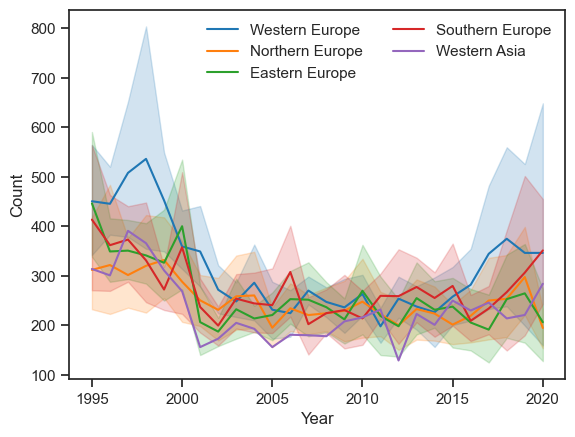

In [15]:
#TODO Plot lingraph: X = Year, Y = Expenses, Lines = Different countries?
ax = sns.lineplot(x="Year", y="Count", hue='Sub-region Name', data=df_speech, palette='tab10')
ax.legend(ncol=2, bbox_to_anchor=(1, 1), frameon=False)

Scatterplot

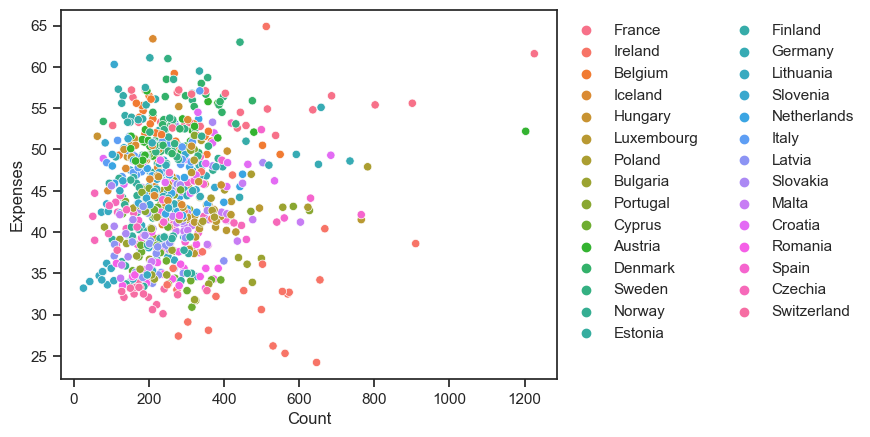

In [16]:
# Scatterplot: X = Year, Y = Expenses, Dot = Country
ax = sns.scatterplot(x="Count", y="Expenses", hue='Country or Area', data=df_speech)
ax.legend(ncol=2, bbox_to_anchor=(1, 1), frameon=False)

Histogram

In [17]:
#TODO Plot histogram: group data by ISO, 

Geopandas

In [18]:
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
europe = world.merge(df_speech, how='inner', left_on='name', right_on='Country or Area')

<AxesSubplot: >

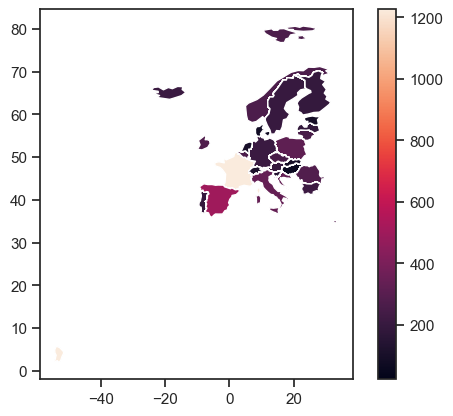

In [19]:
# ax = world.plot(, color='white', edgecolor='black')
fig, ax = plt.subplots(1)
europe.plot(column='Count', ax=ax, legend=True)